In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix

import cv2

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torch.utils.data import random_split
import torch
from torch import nn

from tqdm import tqdm

import models.BaseModel as BaseModel
from models.ResNet18TL import CustomResNet18

In [47]:
device = (torch.device(f"cuda:0") if torch.cuda.is_available() else torch.device("cpu"))

In [48]:
def plot_images(random_batch, k, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    images, labels = random_batch
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)

    for index in range(k):
        image = images[index] * std + mean
        image = np.clip(image.numpy(), 0, 1)  
        
        plt.figure()
        plt.imshow(np.transpose(image, (1, 2, 0)))
        plt.title(f"Image label: {labels[index]}")

def get_predictions(model, eval_data, step=10):
    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim = 1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels

def get_confusion_matrix(model, data_loader, device=device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(10))
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.arange(10),
                yticklabels=np.arange(10))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return cm


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim = 1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score

In [49]:
test_transform_2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_transform_3 = transforms.Compose([
    transforms.Resize(256),  
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

test_dataset_2 = CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=test_transform_2
)

test_dataset_3 = CIFAR10(
    root='./data',
    train=False,
    download=False,
    transform=test_transform_3
)


test_data_loader_2 = torch.utils.data.DataLoader(
    test_dataset_2, batch_size=128, shuffle=False, num_workers=0
)

test_data_loader_3 = torch.utils.data.DataLoader(
    test_dataset_3, batch_size=128, shuffle=False, num_workers=0
)

In [50]:
Model_2 = BaseModel.BaseModel()
Model_2.load_state_dict(torch.load('models/model_2_w.pth'))
Model_2.to(device)
Model_2.eval()

Model_2 = torch.load('models/model_2.pth')

ResNet = CustomResNet18()
Model_3 = ResNet.get_model()
Model_3.load_state_dict(torch.load('models/model_3_w.pth'))
Model_3.to(device)
Model_3.eval()

C:\Users\Terol19\AppData\Local\Temp\ipykernel_24828\3564842193.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Model_2.load_state_dict(torch.load('models/model_2_w.pth')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Посмотрим точность на тестовых данных и матрицу ошибок

In [51]:
Model_2_test_accuracy = get_accuracy(Model_2, test_data_loader_2)
Model_3_test_accuracy = get_accuracy(Model_3, test_data_loader_3)

print("Точность модели 2 на тестовой выборке:", Model_2_test_accuracy)
print("Точность модели 3 на тестовой выборке:", Model_3_test_accuracy)

Точность модели 2 на тестовой выборке: tensor(0.8220)
Точность модели 3 на тестовой выборке: tensor(0.9460)


### Как и ожидалось, дообученный ResNet18 побеждает. Посмотрим на матрицы ошибок.

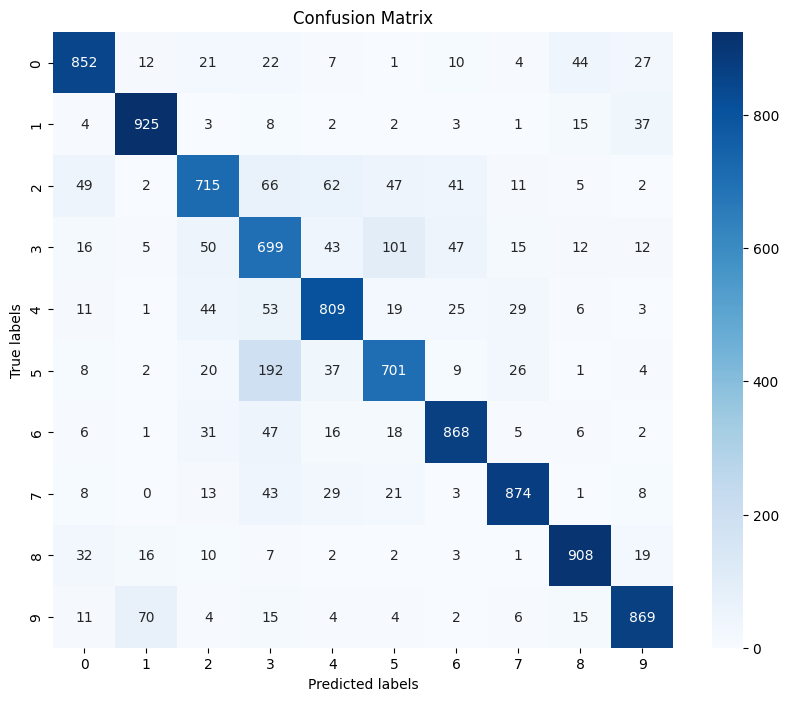

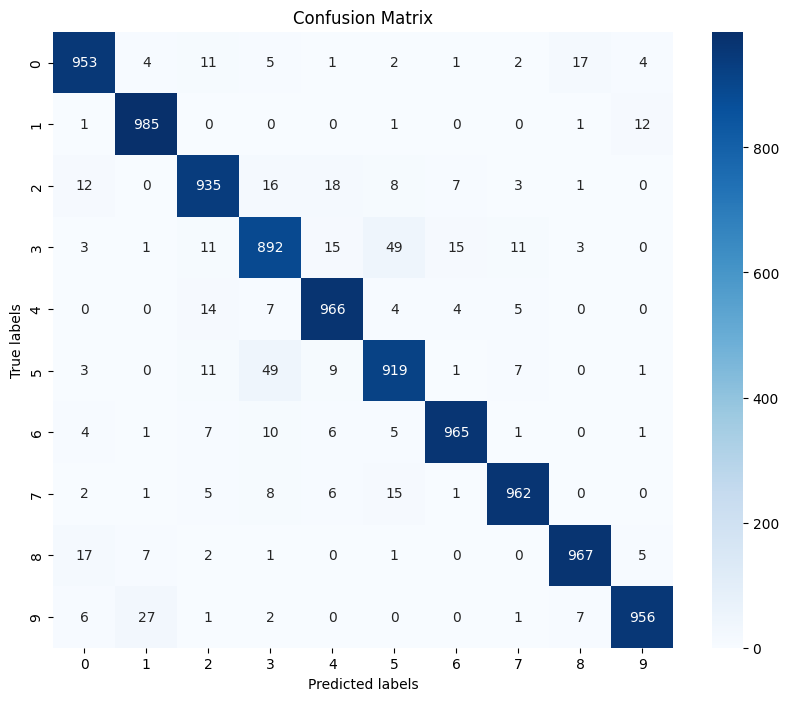

In [53]:
cm2 = get_confusion_matrix(Model_2, test_data_loader_2)
cm3 = get_confusion_matrix(Model_3, test_data_loader_3)

### Как и ожидалось, преобладают значения на диагоналях - то есть модель справляется с задачей. 

### Видно, что модели могут спутать кошек с собаками и наоборот. Даже на диагоналях цвет более светлый, а в клетках (3, 5) и (5, 3) значения выше, чем в других клетках, которые лежат не на диагонале. Кроме того, модели путают машины и грузовики - тоже ожидаемо.